# img2obj

## 準備、処理設定

### 準備

In [8]:
import numpy as np
from numpy.linalg import norm
import math
%pip install matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.collections as mcollections
import matplotlib.colors as mcolors
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import pprint
%pip install triangle
import triangle
import datetime
import cv2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
# matplotlib カラーリストの取得
base_colors = mcolors.BASE_COLORS
base_colors.pop('w', None) # Whiteを削除

print(list(base_colors.keys()))
pprint.pprint(base_colors)

['b', 'g', 'r', 'c', 'm', 'y', 'k']
{'b': (0, 0, 1),
 'c': (0, 0.75, 0.75),
 'g': (0, 0.5, 0),
 'k': (0, 0, 0),
 'm': (0.75, 0, 0.75),
 'r': (1, 0, 0),
 'y': (0.75, 0.75, 0)}


### 処理設定

In [10]:
# 画像の設定
img_folder_path = "/Users/****/Desktop/"
img_name = "sample.png"
img_path = img_folder_path + img_name

# Objの設定
new_obj_name = "New_Obj"
new_obj_folder_path = "/Users/****/Desktop/"

In [11]:
# 処理のパラメーター
round_num_01 = 4
material_adjustment_scale = 2
pixel_to_obj_raito = 0.01
obj_size_scale = 1.0
obj_maxsize = 10
obj_minsize = 1
epsilon_raito = 0.01 # cv2輪郭の頂点の省略率
figure_height = 0.5

In [12]:
figure_height_half = figure_height / 2
is_reverse_list = [False, True]

### 関数

In [13]:
# 確認用の関数
def Get_Color(num, colordict):
  i = (num + 1) % len(colordict)
  key = list(colordict.keys())[i]
  c = colordict[key]
  return c

def Display_Sides_And_Points(side_list, p_list, diff):
  fig = plt.figure(figsize=(10,10),dpi=100)
  ax = fig.add_subplot(1, 1, 1)

  for i in range(len(p_list)):
    color = Get_Color(i, base_colors)
    ax.scatter(p_list[i][0], p_list[i][1], c=color, edgecolors=color)
    ax.text((p_list[i][0] + diff), (p_list[i][1] + diff), str(i), color=color)

  for i in range(len(side_list)):

    color = Get_Color(i, base_colors)
    lines = [[side_list[i][0], side_list[i][1]]]

    lc = mcollections.LineCollection(lines, colors=color)
    ax.add_collection(lc)

    px1 = side_list[i][0][0]
    py1 = side_list[i][0][1]
    px2 = side_list[i][1][0]
    py2 = side_list[i][1][1]
    ax.scatter(px1, py1, s=50, c=color, edgecolors=color)
    ax.scatter(px2, py2, s=50, c=color, edgecolors=color)

    number_str = str(i) + "_"
    ax.text((px1 + diff*(i+0.1)) , (py1 + diff*(i+0.1)), number_str + str(0) , color=color)
    ax.text((px2 + diff*(i+0.1)) , (py2 + diff*(i+0.1)), number_str + str(1), color=color)

  ax.set_aspect ('equal')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  fig.show()

## 画像の取得と前準備、輪郭の取得

(240, 240)


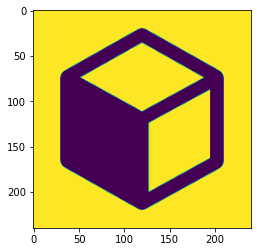

In [14]:
img = cv2.imread(img_path, 0)

if img.all() != None:
    print(img.shape)

    im_list = np.asarray(img)
    plt.imshow(im_list)
    plt.show()
else:
    print("img is empty!")

(260, 260)
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


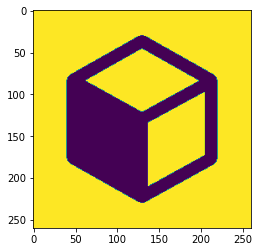

In [15]:
# 2値化
threshold = 150
ret, img_bi = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

img_bi = cv2.copyMakeBorder(img_bi, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=255)
print(img_bi.shape)
print(img_bi[:20])

im_list_bi = np.asarray(img_bi)
plt.imshow(im_list_bi)
plt.show()

In [16]:
# 輪郭の取得
xmin = 0
ymin = 0
# CHAIN_APPROX_NONE
# 　輪郭上のすべての座標を取得します。
# cv2.CHAIN_APPROX_SIMPLE
# 　縦、横、斜め45°方向に完全に直線の部分の輪郭の点を省略します。
# cv2.CHAIN_APPROX_TC89_L1
# 　輪郭の座標を直線で近似できる部分の輪郭の点を省略します。
contours, hierarchy = cv2.findContours(img_bi, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1, offset=(xmin, ymin))

print("contours : " + str(len(contours)))
print(contours[0])
print("contours[1] : " + str(len(contours[1])))
print("shape : " + str(contours[1].shape))
print(contours[1][:3])
print("hierarchy : " + str(len(hierarchy)))
print(hierarchy.shape)
print(hierarchy)

contours : 4
[[[  0   0]]

 [[  0 259]]

 [[259 259]]

 [[259   0]]]
contours[1] : 95
shape : (95, 1, 2)
[[[128  29]]

 [[131  29]]

 [[134  30]]]
hierarchy : 1
(1, 4, 4)
[[[-1 -1  1 -1]
  [-1 -1  2  0]
  [ 3 -1 -1  1]
  [-1  2 -1  1]]]


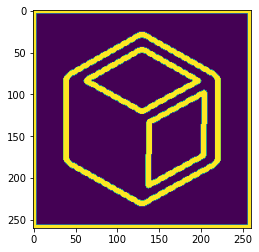

In [17]:
#確認
zero_img = np.zeros_like(img_bi, dtype=np.uint8) 
img_contour = cv2.drawContours(zero_img, contours, -1, (255), thickness=5)

im_list = np.asarray(img_contour)
plt.imshow(im_list)
plt.show()

/var/folders/4l/m0byp3xn42jbp2657xg83hmw0000gn/T/ipykernel_28592/3190859110.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


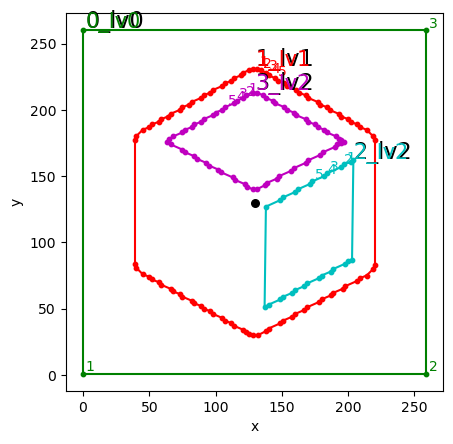

In [18]:
# 確認
data_lists = contours

fig = plt.figure(figsize=(5,5),dpi=100)
ax = fig.add_subplot(1,1,1)

img_h, img_w = img_bi.shape
ax.scatter(img_h/2, img_w/2, s=30, c="black", edgecolors="black")
for i in range(len(data_lists)):
  data = data_lists[i]
  color = Get_Color(i, base_colors)

  for n in range(len(data)):
    px = data[n][0][0]
    py = img_h - data[n][0][1]
    ax.scatter(px, py, s=10, c=color, edgecolors=color)

  lines = []
  for c in range(len(data)):
    line = []
    p_a = [data[c][0][0], (img_h - data[c][0][1])]
    if c != len(data) - 1:
      p_b = [data[c+1][0][0], (img_h - data[c+1][0][1])]
    else:
      p_b = [data[0][0][0], (img_h - data[0][0][1])]
    line = [p_a, p_b]
    lines.append(line)

    if c == 0:
      level = hierarchy[0][i][3] + 1
      ax.text(line[0][0] + 2, line[0][1] + 2, str(i) + "_lv" + str(level), color="black", fontsize=16)
      ax.text(line[0][0] + 2, line[0][1] + 2, str(i) + "_lv" + str(level), color=color, fontsize=15)
    elif c < 6:
      ax.text(line[0][0] + 2, line[0][1] + 2, str(c), color=color, fontsize=10)


  lc = mcollections.LineCollection(lines, colors=color)
  ax.add_collection(lc)

ax.set_aspect ('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

In [19]:
print("contours[1] : " + str(len(contours[1])))
print(contours[1][:8])

# 輪郭の大きさの取得
cnt_lefttop_x, cnt_lefttop_y, cnt_width, cnt_height = cv2.boundingRect(contours[1])
cnt_size = cnt_width
if cnt_size < cnt_height:
    cnt_size = cnt_height

# サイズ調整のスケールの取得
obj_sizing_scale = 1.0
cnt_size = cnt_size * pixel_to_obj_raito * obj_size_scale
if cnt_size > obj_maxsize and obj_maxsize > obj_minsize:
    obj_sizing_scale = obj_maxsize / cnt_size
elif cnt_size < obj_minsize and obj_maxsize > obj_minsize:
    obj_sizing_scale = obj_minsize / cnt_size

# 輪郭のポイントの省略処理
epsilon = epsilon_raito * cv2.arcLength(contours[1],True)
approx_curve_list = []
for i in range(len(contours)):
    curve = cv2.approxPolyDP(contours[i], epsilon=epsilon, closed=True)
    approx_curve_list.append(curve)

approx_curve = approx_curve_list[1]

print("approx_curve_list : " + str(len(approx_curve_list)))
print(approx_curve_list)

print("approx_curve : " + str(len(approx_curve)))
print(approx_curve[:8])

figure_position_2d_original = np.array(approx_curve)
print("figure_position_2d_original.shape")
print(figure_position_2d_original.shape)

figure_position_2d_original = figure_position_2d_original.reshape(len(figure_position_2d_original), 2)
print(contours[1][:8])
print("figure_position_2d_original.shape")
print(figure_position_2d_original.shape)

contours[1] : 95
[[[128  29]]

 [[131  29]]

 [[134  30]]

 [[138  32]]

 [[140  34]]

 [[145  36]]

 [[147  38]]

 [[152  40]]]
approx_curve_list : 4
[array([[[  0,   0]],

       [[  0, 259]],

       [[259, 259]],

       [[259,   0]]], dtype=int32), array([[[128,  29]],

       [[220,  83]],

       [[219, 180]],

       [[132, 230]],

       [[ 39, 176]],

       [[ 40,  80]]], dtype=int32), array([[[204,  98]],

       [[138, 133]],

       [[137, 209]],

       [[203, 173]]], dtype=int32), array([[[ 63,  84]],

       [[128, 120]],

       [[197,  84]],

       [[131,  47]]], dtype=int32)]
approx_curve : 6
[[[128  29]]

 [[220  83]]

 [[219 180]]

 [[132 230]]

 [[ 39 176]]

 [[ 40  80]]]
figure_position_2d_original.shape
(6, 1, 2)
[[[128  29]]

 [[131  29]]

 [[134  30]]

 [[138  32]]

 [[140  34]]

 [[145  36]]

 [[147  38]]

 [[152  40]]]
figure_position_2d_original.shape
(6, 2)


In [20]:
# ポジションのスケール調整関数
img_h, img_w = img_bi.shape
def PositionListWithScaleAdded(old_list, obj_raito, size_scale, sizing_scale, round_n):
    new_list = []
    for i in range(len(old_list)):
        old_p = old_list[i]
        px = old_p[0] * obj_raito * size_scale * sizing_scale
        py = (img_h - old_p[1]) * obj_raito * size_scale * sizing_scale
        new_p = [round(px, round_n), round(py, round_n)]
        new_list.append(new_p)
        
    return new_list

In [21]:
tmp_list = PositionListWithScaleAdded(figure_position_2d_original, pixel_to_obj_raito, obj_size_scale, obj_sizing_scale, round_num_01)

if is_reverse_list[0] == True:
    tmp_list.reverse()

figure_position_2d_original = np.array(tmp_list)
print("figure_position_2d_original : " + str(len(figure_position_2d_original)))
print(figure_position_2d_original[:8])

figure_position_2d_original : 6
[[1.28 2.31]
 [2.2  1.77]
 [2.19 0.8 ]
 [1.32 0.3 ]
 [0.39 0.84]
 [0.4  1.8 ]]


### 準備、図形の頂点データを使用

In [22]:
figure_position_2d_markers = []

for i in range(len(figure_position_2d_original)):
    figure_position_2d_markers.append(2)
figure_position_2d_markers= np.array(figure_position_2d_markers)

In [23]:
figure_segment = []
figure_segment_markers = []

for i in range(len(figure_position_2d_original)):
    if i != len(figure_position_2d_original) -1:
        seg = [i, i + 1]
    else:
        seg = [i, 0]
    figure_segment.append(seg)
    figure_segment_markers.append(2)
    
figure_segment = np.array(figure_segment)
figure_segment_markers = np.array(figure_segment_markers)

print("figure_position_2d_original : " + str(len(figure_position_2d_original)))
print(figure_position_2d_original[:8])
print("figure_position_2d_markers : " + str(len(figure_position_2d_markers)))
print(figure_position_2d_markers[:8])
print("figure_segment : " + str(len(figure_segment)))
print(figure_segment[:8])
print("figure_segment_markers : " + str(len(figure_segment_markers)))
print(figure_segment_markers[:8])

figure_position_2d_original : 6
[[1.28 2.31]
 [2.2  1.77]
 [2.19 0.8 ]
 [1.32 0.3 ]
 [0.39 0.84]
 [0.4  1.8 ]]
figure_position_2d_markers : 6
[2 2 2 2 2 2]
figure_segment : 6
[[0 1]
 [1 2]
 [2 3]
 [3 4]
 [4 5]
 [5 0]]
figure_segment_markers : 6
[2 2 2 2 2 2]


#### ホール(穴)データの作成
(座標リストの作成、スケール調整、辺のリスト、辺の番号リストの作成)

#### 作成。ホールの中心点、周囲の長さも取得

In [24]:
holes_num_list = []
holes_position_list_original = []
holes_cp_list_original = []

# 各ホールのデータ格納番号の取得
first_child_num = hierarchy[0][1][2]
if first_child_num != -1:
    print("Halls exist.\n")

    next_num = first_child_num
    while next_num != -1:
        holes_num_list.append(next_num)
        next_num = hierarchy[0][next_num][0]

else:
    print("Halls does not exist.")

for i in range(len(holes_num_list)):
    num = holes_num_list[i]
    data = np.array(approx_curve_list[num])
    data = data.reshape(len(data), 2)
    print("hole " + str(i) + " : " + str(len(data)))
    data = PositionListWithScaleAdded(data, pixel_to_obj_raito, obj_size_scale, obj_sizing_scale, round_num_01)
    if is_reverse_list[1] == True:
        data.reverse()
    holes_position_list_original.append(data)

# 各ホールの中心点の取得
for i in range(len(holes_position_list_original)):
    data = holes_position_list_original[i]

    total_x = 0
    total_y = 0

    for n in range(len(data)):
        total_x += data[n][0]
        total_y += data[n][1]

    cpx = total_x / len(data)
    cpy = total_y / len(data)

    hole_cp = [round(cpx, round_num_01), round(cpy, round_num_01)]
    holes_cp_list_original.append(hole_cp)


print("\nholes_num_list : " + str(len(holes_num_list)))
print(holes_num_list)

print("\nholes_position_list_original : " + str(len(holes_position_list_original)))
for i in range(len(holes_position_list_original)):
    print("  holes_position_list_original[" + str(i) + "] : " + str(len(holes_position_list_original[i])))
print(holes_position_list_original)

print("\nholes_cp_list : " + str(len(holes_cp_list_original)))
print(holes_cp_list_original)

Halls exist.

hole 0 : 4
hole 1 : 4

holes_num_list : 2
[2, 3]

holes_position_list_original : 2
  holes_position_list_original[0] : 4
  holes_position_list_original[1] : 4
[[[2.03, 0.87], [1.37, 0.51], [1.38, 1.27], [2.04, 1.62]], [[1.31, 2.13], [1.97, 1.76], [1.28, 1.4], [0.63, 1.76]]]

holes_cp_list : 2
[[1.705, 1.0675], [1.2975, 1.7625]]


In [25]:
holes_position_markers_list =[]
holes_segments_list = []
holes_segment_markers_list =[]

start_num = 2 + 1
for i in range(len(holes_position_list_original)):
    data = holes_position_list_original[i]
    num = start_num + i

    markers_list = []
    for n in range(len(data)):
        markers_list.append(num)
    
    holes_position_markers_list.append(markers_list)

additional_num = len(figure_position_2d_original)
for i in range(len(holes_position_list_original)):
    data = holes_position_list_original[i]

    segments_list = []
    for n in range(len(data)):
        n1 = n + additional_num
        n2 = n + 1 + additional_num
        if n == len(data) - 1:
            n2 = 0 + additional_num
        segment = [n1, n2]
        segments_list.append(segment)

    holes_segments_list.append(segments_list)
    additional_num =  additional_num + len(data)

for i in range(len(holes_segments_list)):
    data = holes_segments_list[i]
    num = start_num + i

    markers_list = []
    for n in range(len(data)):
        markers_list.append(num)
    
    holes_segment_markers_list.append(markers_list)


print("holes_position_list_original : " + str(len(holes_position_list_original)))
for i in range(len(holes_position_list_original)):
    print("  holes_position_list[" + str(i) + "] : " + str(len(holes_position_list_original[i])))
print(holes_position_list_original[:2][:2])

print("\nholes_position_markers_list : " + str(len(holes_position_markers_list)))
for i in range(len(holes_position_markers_list)):
    print("  holes_position_markers_list[" + str(i) + "] : " + str(len(holes_position_markers_list[i])))
print(holes_position_markers_list[:2][:2])

print("\nholes_segments_list : " + str(len(holes_segments_list)))
for i in range(len(holes_segments_list)):
    print("  holes_segments_list[" + str(i) + "] : " + str(len(holes_segments_list[i])))
print(holes_segments_list[:2][:2])

print("\nholes_segment_markers_list : " + str(len(holes_segment_markers_list)))
for i in range(len(holes_segment_markers_list)):
    print("  holes_segment_markers_list[" + str(i) + "] : " + str(len(holes_segment_markers_list[i])))
print(holes_segment_markers_list[:2][:2])

holes_position_list_original : 2
  holes_position_list[0] : 4
  holes_position_list[1] : 4
[[[2.03, 0.87], [1.37, 0.51], [1.38, 1.27], [2.04, 1.62]], [[1.31, 2.13], [1.97, 1.76], [1.28, 1.4], [0.63, 1.76]]]

holes_position_markers_list : 2
  holes_position_markers_list[0] : 4
  holes_position_markers_list[1] : 4
[[3, 3, 3, 3], [4, 4, 4, 4]]

holes_segments_list : 2
  holes_segments_list[0] : 4
  holes_segments_list[1] : 4
[[[6, 7], [7, 8], [8, 9], [9, 6]], [[10, 11], [11, 12], [12, 13], [13, 10]]]

holes_segment_markers_list : 2
  holes_segment_markers_list[0] : 4
  holes_segment_markers_list[1] : 4
[[3, 3, 3, 3], [4, 4, 4, 4]]


In [26]:
holes_norms_list = []
holes_perimeters_list = []

for i in range(len(holes_position_list_original)):
    data = np.array(holes_position_list_original[i])

    fp = 0
    norms_list = []
    for n in range(len(data)):
        if n == (len(data) - 1):
            norm = np.linalg.norm(data[n]-data[0])
            fp += norm
        else:
            norm = np.linalg.norm(data[n]-data[n+1])
            fp += norm
        norms_list.append(norm)

    holes_norms_list.append(norms_list)
    holes_perimeters_list.append(fp)


print("holes_norms_list : " + str(len(holes_norms_list)))
for i in range(len(holes_norms_list)):
    print("  holes_norms_list[" + str(i) + "] : " + str(len(holes_norms_list[i])))
print(holes_norms_list[:2][:2])

print("\nholes_perimeters_list : " + str(len(holes_perimeters_list)))
print(holes_perimeters_list)

holes_norms_list : 2
  holes_norms_list[0] : 4
  holes_norms_list[1] : 4
[[0.7517978451684998, 0.7600657866263946, 0.7470609078247906, 0.7500666637039672], [0.7566372975210777, 0.7782673062643709, 0.743034319530397, 0.7741446893184762]]

holes_perimeters_list : 2
[3.008991203323652, 3.052083612634322]


#### 図形の中心点

In [27]:
total_x = 0
total_y = 0

for i in range(len(figure_position_2d_original)):
    total_x += figure_position_2d_original[i][0]
    total_y += figure_position_2d_original[i][1]

cpx = total_x / len(figure_position_2d_original)
cpy = total_y / len(figure_position_2d_original)

figure_cp = [round(cpx, round_num_01), round(cpy, round_num_01)]
print("figure_cp : " + str(figure_cp))

figure_cp : [1.2967, 1.3033]


#### 図形の周囲の長さ

In [28]:
outer_side_norm_list = []
figure_perimeter = 0

# 図形の全周の長さを算出
fp = 0
for i in range(len(figure_position_2d_original)):
  if i == (len(figure_position_2d_original) - 1):
    norm = np.linalg.norm(figure_position_2d_original[i]-figure_position_2d_original[0])
    fp += norm
    outer_side_norm_list.append(norm)
  else:
    norm = np.linalg.norm(figure_position_2d_original[i]-figure_position_2d_original[i+1])
    fp += norm
    outer_side_norm_list.append(norm)

print("outer_side_norm_list : " + str(len(outer_side_norm_list)))
print(outer_side_norm_list)
figure_perimeter = round(fp, round_num_01)
print("figure_perimeter : " + str(figure_perimeter))

outer_side_norm_list : 6
[1.0667708282475672, 0.970051545022222, 1.0034440691936946, 1.0754068997360953, 0.9600520819205592, 1.0171037311896953]
figure_perimeter : 6.0928


/var/folders/4l/m0byp3xn42jbp2657xg83hmw0000gn/T/ipykernel_28592/2723710238.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


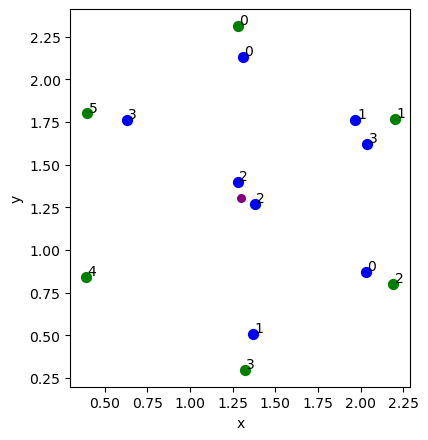

In [29]:
# 確認
fig = plt.figure(figsize=(5,5),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.scatter(figure_cp[0], figure_cp[1], s=30, c="purple", edgecolors="purple")
ax.scatter(0, 0, s=30, c="red", edgecolors="red")
for n in range(len(figure_position_2d_original)):
  px = figure_position_2d_original[n][0]
  py = figure_position_2d_original[n][1]
  ax.scatter(px, py, s=50, c="green", edgecolors="green")

  number = n
  ax.text((px + 0.01) , (py + 0.01), str(number))

for i in range(len(holes_position_list_original)):
  data = holes_position_list_original[i]
  for n in range(len(data)):
    px = data[n][0]
    py = data[n][1]
    ax.scatter(px, py, s=50, c="blue", edgecolors="blue")

    number = n
    ax.text((px + 0.01) , (py + 0.01), str(number))
ax.set_aspect ('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

#### 中心点に合わせて頂点座標を調整

In [30]:
figure_position_2d = []

for i in range(len(figure_position_2d_original)):
    old_p = figure_position_2d_original[i]
    px = old_p[0] - figure_cp[0]
    py = old_p[1] - figure_cp[1]
    new_p = [round(px, round_num_01), round(py, round_num_01)]
    figure_position_2d.append(new_p)

print("figure_position_2d : " + str(len(figure_position_2d)))
print(figure_position_2d)

figure_position_2d : 6
[[-0.0167, 1.0067], [0.9033, 0.4667], [0.8933, -0.5033], [0.0233, -1.0033], [-0.9067, -0.4633], [-0.8967, 0.4967]]


In [31]:
# ホール
holes_position_list = []
hole_cp_list = []

for i in range(len(holes_position_list_original)):
    data = holes_position_list_original[i]

    tmp_list = []
    for n in range(len(data)):
        old_p = data[n]
        px = old_p[0] - figure_cp[0]
        py = old_p[1] - figure_cp[1]
        new_p = [round(px, round_num_01), round(py, round_num_01)]
        tmp_list.append(new_p)
    holes_position_list.append(tmp_list)

for i in range(len(holes_cp_list_original)):
    old_cp = holes_cp_list_original[i]
    pcx = old_cp[0] - figure_cp[0]
    pcy = old_cp[1] - figure_cp[1]
    new_cp = [round(pcx, round_num_01), round(pcy, round_num_01)]
    hole_cp_list.append(new_cp)


print("holes_position_list : " + str(len(holes_position_list)))
for i in range(len(holes_position_list)):
    print("  holes_position_list[" + str(i) + "] : " + str(len(holes_position_list[i])))
print(holes_position_list[:2][:2])

print("\nhole_cp_list : " + str(len(hole_cp_list)))
for i in range(len(hole_cp_list)):
    print("  hole_cp_list[" + str(i) + "] : " + str(len(hole_cp_list[i])))
print(hole_cp_list[:2][:2])

holes_position_list : 2
  holes_position_list[0] : 4
  holes_position_list[1] : 4
[[[0.7333, -0.4333], [0.0733, -0.7933], [0.0833, -0.0333], [0.7433, 0.3167]], [[0.0133, 0.8267], [0.6733, 0.4567], [-0.0167, 0.0967], [-0.6667, 0.4567]]]

hole_cp_list : 2
  hole_cp_list[0] : 2
  hole_cp_list[1] : 2
[[0.4083, -0.2358], [0.0008, 0.4592]]


/var/folders/4l/m0byp3xn42jbp2657xg83hmw0000gn/T/ipykernel_28592/2510377857.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


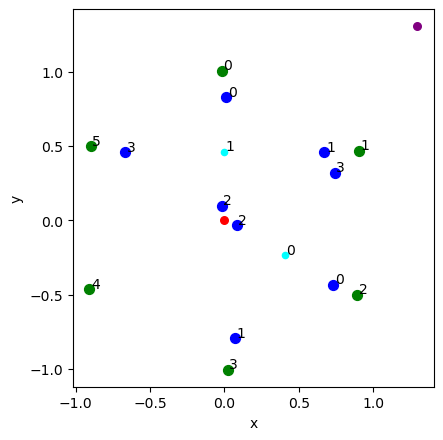

In [32]:
# 確認
fig = plt.figure(figsize=(5,5),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.scatter(figure_cp[0], figure_cp[1], s=30, c="purple", edgecolors="purple")
ax.scatter(0, 0, s=30, c="red", edgecolors="red")
for n in range(len(figure_position_2d)):
  px = figure_position_2d[n][0]
  py = figure_position_2d[n][1]
  ax.scatter(px, py, s=50, c="green", edgecolors="green")

  number = n
  ax.text((px + 0.01) , (py + 0.01), str(number))

for i in range(len(holes_position_list)):
  data = holes_position_list[i]
  for n in range(len(data)):
    px = data[n][0]
    py = data[n][1]
    ax.scatter(px, py, s=50, c="blue", edgecolors="blue")

    number = n
    ax.text((px + 0.01) , (py + 0.01), str(number))

for n in range(len(hole_cp_list)):
  px = hole_cp_list[n][0]
  py = hole_cp_list[n][1]
  ax.scatter(px, py, s=20, c="cyan", edgecolors="cyan")

  number = n
  ax.text((px + 0.01) , (py + 0.01), str(number))
  
ax.set_aspect ('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

## Triangleデータの作成

### Triangulator(三角測量)

In [33]:
figure = {}
figure["vertices"] = np.array(figure_position_2d)
figure["vertex_markers"] = np.array(figure_position_2d_markers)
figure["segments"] = np.array(figure_segment)
figure["segment_markers"] = np.array(figure_segment_markers)

if len(holes_position_list) != 0:
    vertices_list = figure_position_2d
    vertex_markers_list = list(figure_position_2d_markers)
    segments_list = list(figure_segment)
    segment_markers_list = list(figure_segment_markers)

    for i in range(len(holes_position_list)):
        vertices_list = vertices_list + holes_position_list[i]
        vertex_markers_list = vertex_markers_list + holes_position_markers_list[i]
        segments_list = segments_list + holes_segments_list[i]
        segment_markers_list = segment_markers_list + holes_segment_markers_list[i]

    figure["vertices"] = np.array(vertices_list)
    figure["vertex_markers"] = np.array(vertex_markers_list)
    figure["segments"] = np.array(segments_list)
    figure["segment_markers"] = np.array(segment_markers_list)
    figure["holes"] = np.array(hole_cp_list)

# 確認
print(type(figure))

result = triangle.triangulate(figure, 'p')


print("\nresult")
for i in range(len(result)):
    data_key = list(result.keys())[i]
    print(str(data_key) + " : " + str(len(result[str(data_key)])))

print("\nresult[vertices] : " + str(len(result["vertices"])))
print(result["vertices"][:8])

print("result[triangles] : " + str(len(result["triangles"])))
print(result["triangles"][:8])

<class 'dict'>

result
vertices : 14
vertex_markers : 14
triangles : 16
segments : 14
segment_markers : 14
holes : 2

result[vertices] : 14
[[-0.0167  1.0067]
 [ 0.9033  0.4667]
 [ 0.8933 -0.5033]
 [ 0.0233 -1.0033]
 [-0.9067 -0.4633]
 [-0.8967  0.4967]
 [ 0.7333 -0.4333]
 [ 0.0733 -0.7933]]
result[triangles] : 16
[[12  4  8]
 [ 4 12 13]
 [ 5 13  0]
 [13  5  4]
 [ 0 10 11]
 [10  0 13]
 [ 7  4  3]
 [ 7  2  6]]


/var/folders/4l/m0byp3xn42jbp2657xg83hmw0000gn/T/ipykernel_28592/1755170740.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


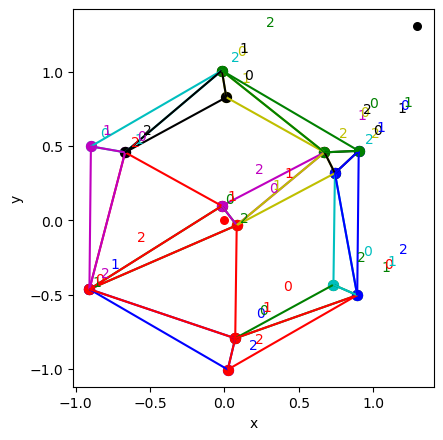

In [34]:
# 確認
rt = result["triangles"]

tmp_all_position = figure_position_2d
for i in range(len(holes_position_list)):
  tmp_all_position = tmp_all_position + holes_position_list[i]

fig = plt.figure(figsize=(5,5),dpi=100)
ax = fig.add_subplot(1,1,1)
ax.scatter(figure_cp[0], figure_cp[1], s=30, c="black", edgecolors="black")
ax.scatter(0, 0, s=30, c="red", edgecolors="red")

for i in range(len(rt)):
  t = rt[i]
  color = Get_Color(i, base_colors)

  lines = [[tmp_all_position[t[0]], tmp_all_position[t[1]]], [tmp_all_position[t[1]], tmp_all_position[t[2]]], [tmp_all_position[t[2]], tmp_all_position[t[0]]]]

  lc = mcollections.LineCollection(lines, colors=color)
  ax.add_collection(lc)

  for n in range(len(t)):
    px = tmp_all_position[t[n]][0]
    py = tmp_all_position[t[n]][1]
    ax.scatter(px, py, s=50, c=color, edgecolors=color)

    number = n
    ax.text((px + 0.02*(i+1)) , (py + 0.02*(i+1)), str(number), color=color)

ax.set_aspect ('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

## 立体化

### 頂点データの追加

In [35]:
# position
top_surface_position = []
bottom_surface_position = []
top_surface_position_only_holes_list = []
bottom_surface_position_only_holes_list = []

figure_holes_position = []
figure_position_with_holes = []

for i in range(len(holes_position_list)):
  data = holes_position_list[i]

  tp_list = []
  bp_list = []
  for n in range(len(data)):
    p = data[n]
    tp = (p[0], figure_height_half, p[1])
    bp = (p[0], -figure_height_half, p[1])

    tp_list.append(tp)
    bp_list.append(bp)
  top_surface_position_only_holes_list.append(tp_list)
  bottom_surface_position_only_holes_list.append(bp_list)

for i in range(len(holes_position_list)):
  figure_holes_position = figure_holes_position + holes_position_list[i]

figure_position_with_holes = figure_position_2d + figure_holes_position

for i in range(len(figure_position_with_holes)):
  p = figure_position_with_holes[i]
  tp = (p[0], figure_height_half, p[1])
  bp = (p[0], -figure_height_half, p[1])

  top_surface_position.append(tp)
  bottom_surface_position.append(bp)

print("figure_holes_position : " + str(len(figure_holes_position)))
print(figure_holes_position[:])
print("figure_position_with_holes : " + str(len(figure_position_with_holes)))
print(figure_position_with_holes[:])
print("top_surface_position_only_holes_list : " + str(len(top_surface_position_only_holes_list)))
print(top_surface_position_only_holes_list[:])
print("bottom_surface_position_only_holes_list : " + str(len(bottom_surface_position_only_holes_list)))
print(bottom_surface_position_only_holes_list[:])
print("top_surface_position : " + str(len(top_surface_position)))
print(top_surface_position[:])
print("bottom_surface_position : " + str(len(bottom_surface_position)))
print(bottom_surface_position[:])

figure_holes_position : 8
[[0.7333, -0.4333], [0.0733, -0.7933], [0.0833, -0.0333], [0.7433, 0.3167], [0.0133, 0.8267], [0.6733, 0.4567], [-0.0167, 0.0967], [-0.6667, 0.4567]]
figure_position_with_holes : 14
[[-0.0167, 1.0067], [0.9033, 0.4667], [0.8933, -0.5033], [0.0233, -1.0033], [-0.9067, -0.4633], [-0.8967, 0.4967], [0.7333, -0.4333], [0.0733, -0.7933], [0.0833, -0.0333], [0.7433, 0.3167], [0.0133, 0.8267], [0.6733, 0.4567], [-0.0167, 0.0967], [-0.6667, 0.4567]]
top_surface_position_only_holes_list : 2
[[(0.7333, 0.25, -0.4333), (0.0733, 0.25, -0.7933), (0.0833, 0.25, -0.0333), (0.7433, 0.25, 0.3167)], [(0.0133, 0.25, 0.8267), (0.6733, 0.25, 0.4567), (-0.0167, 0.25, 0.0967), (-0.6667, 0.25, 0.4567)]]
bottom_surface_position_only_holes_list : 2
[[(0.7333, -0.25, -0.4333), (0.0733, -0.25, -0.7933), (0.0833, -0.25, -0.0333), (0.7433, -0.25, 0.3167)], [(0.0133, -0.25, 0.8267), (0.6733, -0.25, 0.4567), (-0.0167, -0.25, 0.0967), (-0.6667, -0.25, 0.4567)]]
top_surface_position : 14
[(-0.

#### 側面とホールのIndexリストの作成

In [36]:
top_surface_position_length = len(top_surface_position)
figure_holes_position_length = len(figure_holes_position)
outer_side_position_length = top_surface_position_length - figure_holes_position_length

outer_side_index_list = []
inner_side_index_list = []

# Outer
for i in range(outer_side_position_length):
    n1 = i
    n2 = i
    index = n2
    outer_side_index_list.append(index)
for i in range(outer_side_position_length):
    n1 = i + outer_side_position_length
    n2 = i + top_surface_position_length
    index = n2
    outer_side_index_list.append(index)

# Inner
additional_num = 0
for i in range(len(holes_position_list_original)):
    data = holes_position_list_original[i]
    inner_side_position_length = len(data)
    print("inner_side_position_length[" + str(i) +"] : " + str(inner_side_position_length))
    index_list = []

    for n in range(inner_side_position_length):
        n1 = n
        n2 = n + outer_side_position_length + additional_num
        index = n2
        index_list.append(index)
    for n in range(inner_side_position_length):
        n2 = n + top_surface_position_length + outer_side_position_length + additional_num
        index = n2
        index_list.append(index)

    additional_num += inner_side_position_length
    inner_side_index_list.append(index_list)

print("top_surface_position_length : " + str(top_surface_position_length))
print("figure_holes_position_length : " + str(figure_holes_position_length))
print("outer_side_position_length : " + str(outer_side_position_length))
print("outer_side_index_list : " + str(len(outer_side_index_list)))
print(outer_side_index_list[:])
print("inner_side_index_list : " + str(len(inner_side_index_list)))
print(inner_side_index_list[:])

inner_side_position_length[0] : 4
inner_side_position_length[1] : 4
top_surface_position_length : 14
figure_holes_position_length : 8
outer_side_position_length : 6
outer_side_index_list : 12
[0, 1, 2, 3, 4, 5, 14, 15, 16, 17, 18, 19]
inner_side_index_list : 2
[[6, 7, 8, 9, 20, 21, 22, 23], [10, 11, 12, 13, 24, 25, 26, 27]]


In [37]:
# triangle
top_surface_triangle = []
bottom_surface_triangle = []

top_surface_triangle = result["triangles"].tolist() 
for i in range(len(top_surface_triangle)):
  top_surface_triangle[i].reverse()
bottom_surface_triangle = result["triangles"].tolist()

print("top_surface_triangle : " + str(len(top_surface_triangle)))
print(top_surface_triangle[:])
print("bottom_surface_triangle : " + str(len(bottom_surface_triangle)))
print(bottom_surface_triangle[:])

top_surface_triangle : 16
[[8, 4, 12], [13, 12, 4], [0, 13, 5], [4, 5, 13], [11, 10, 0], [13, 0, 10], [3, 4, 7], [6, 2, 7], [3, 7, 2], [9, 2, 6], [12, 11, 8], [9, 8, 11], [11, 1, 9], [2, 9, 1], [0, 1, 11], [4, 8, 7]]
bottom_surface_triangle : 16
[[12, 4, 8], [4, 12, 13], [5, 13, 0], [13, 5, 4], [0, 10, 11], [10, 0, 13], [7, 4, 3], [7, 2, 6], [2, 7, 3], [6, 2, 9], [8, 11, 12], [11, 8, 9], [9, 1, 11], [1, 9, 2], [11, 1, 0], [7, 8, 4]]


In [38]:
outer_side_surface_triangle = []
inner_side_surface_triangle_list = []
inner_side_surface_triangle = []

sft = []
n = 0
additional_num = len(figure_holes_position)
for i in range(len(figure_position_2d)):
  pn1 = n + 1 + len(figure_position_2d) + additional_num
  pn2 = n + 1
  pn3 = n
  if pn2 == len(figure_position_2d):
    pn1 = len(figure_position_2d) + additional_num
    pn2 = 0
  pl1 = [pn1, pn2, pn3]

  pn4 = n
  pn5 = n + len(figure_position_2d) + additional_num
  pn6 = n + 1 + len(figure_position_2d) + additional_num
  if pn6 == (len(figure_position_2d)*2 + additional_num):
    pn6 = len(figure_position_2d) + additional_num
  pl2 = [pn4, pn5, pn6]

  sft.append(pl1)
  sft.append(pl2)

  n += 1

outer_side_surface_triangle = sft


top_start_num = len(figure_position_2d)
bottom_start_num = len(figure_position_2d) * 2 + len(figure_holes_position)
for i in range(len(holes_position_list)):
  data = holes_position_list[i]

  sft = []
  p = 0
  for n in range(len(data)):
    pn1 = p + 1 + bottom_start_num
    pn2 = p + 1 + top_start_num
    pn3 = p + top_start_num
    if pn2 == (len(data) + top_start_num):
      pn1 = bottom_start_num
      pn2 = 0 + top_start_num
    pl1 = [pn3, pn2, pn1]

    pn4 = p + top_start_num
    pn5 = p + bottom_start_num
    pn6 = p + 1 + bottom_start_num
    if pn6 == (len(data) + bottom_start_num):
      pn6 = bottom_start_num
    pl2 = [pn6, pn5, pn4]

    sft.append(pl1)
    sft.append(pl2)
    inner_side_surface_triangle.append(pl1)
    inner_side_surface_triangle.append(pl2)

    p += 1
    start_num = start_num + len(data)

  top_start_num += len(data)
  bottom_start_num += len(data)
  inner_side_surface_triangle_list.append(sft)


print("outer_side_surface_triangle : " + str(len(outer_side_surface_triangle)))
print(outer_side_surface_triangle[:])
print("inner_side_surface_triangle_list : " + str(len(inner_side_surface_triangle_list)))
print(inner_side_surface_triangle_list[:])
print("inner_side_surface_triangle : " + str(len(inner_side_surface_triangle)))
print(inner_side_surface_triangle[:])

outer_side_surface_triangle : 12
[[15, 1, 0], [0, 14, 15], [16, 2, 1], [1, 15, 16], [17, 3, 2], [2, 16, 17], [18, 4, 3], [3, 17, 18], [19, 5, 4], [4, 18, 19], [14, 0, 5], [5, 19, 14]]
inner_side_surface_triangle_list : 2
[[[6, 7, 21], [21, 20, 6], [7, 8, 22], [22, 21, 7], [8, 9, 23], [23, 22, 8], [9, 6, 20], [20, 23, 9]], [[10, 11, 25], [25, 24, 10], [11, 12, 26], [26, 25, 11], [12, 13, 27], [27, 26, 12], [13, 10, 24], [24, 27, 13]]]
inner_side_surface_triangle : 16
[[6, 7, 21], [21, 20, 6], [7, 8, 22], [22, 21, 7], [8, 9, 23], [23, 22, 8], [9, 6, 20], [20, 23, 9], [10, 11, 25], [25, 24, 10], [11, 12, 26], [26, 25, 11], [12, 13, 27], [27, 26, 12], [13, 10, 24], [24, 27, 13]]


In [39]:
all_triangle_num = top_surface_triangle + outer_side_surface_triangle + inner_side_surface_triangle + bottom_surface_triangle

print("all_triangle_num : " + str(len(all_triangle_num)))
print(all_triangle_num[:])

all_triangle_num : 60
[[8, 4, 12], [13, 12, 4], [0, 13, 5], [4, 5, 13], [11, 10, 0], [13, 0, 10], [3, 4, 7], [6, 2, 7], [3, 7, 2], [9, 2, 6], [12, 11, 8], [9, 8, 11], [11, 1, 9], [2, 9, 1], [0, 1, 11], [4, 8, 7], [15, 1, 0], [0, 14, 15], [16, 2, 1], [1, 15, 16], [17, 3, 2], [2, 16, 17], [18, 4, 3], [3, 17, 18], [19, 5, 4], [4, 18, 19], [14, 0, 5], [5, 19, 14], [6, 7, 21], [21, 20, 6], [7, 8, 22], [22, 21, 7], [8, 9, 23], [23, 22, 8], [9, 6, 20], [20, 23, 9], [10, 11, 25], [25, 24, 10], [11, 12, 26], [26, 25, 11], [12, 13, 27], [27, 26, 12], [13, 10, 24], [24, 27, 13], [12, 4, 8], [4, 12, 13], [5, 13, 0], [13, 5, 4], [0, 10, 11], [10, 0, 13], [7, 4, 3], [7, 2, 6], [2, 7, 3], [6, 2, 9], [8, 11, 12], [11, 8, 9], [9, 1, 11], [1, 9, 2], [11, 1, 0], [7, 8, 4]]


#### 上面下面の頂点結合、側面Normal作成

In [40]:
# 上面下面の結合
position_with_hole = top_surface_position + bottom_surface_position
position_only_hole_list = top_surface_position_only_holes_list + bottom_surface_position_only_holes_list

outer_side_normal = []
inner_side_normal = []

num = len(figure_position_2d)
additional_num = len(figure_holes_position)

for i in range(num):
  if i != (num-1):
    p_num1 = i
    p_num2 = i + 1
    p_num3 = i + num + 1 + additional_num

    p1 = position_with_hole[p_num1]
    p2 = position_with_hole[p_num2]
    p3 = position_with_hole[p_num3]

    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    c = np.cross(v1, v2)
    n_c = np.linalg.norm(c)
    u = c / n_c

    outer_side_normal.append(u)
  else:
    p_num1 = i
    p_num2 = 0
    p_num3 = 0 + num + additional_num

    p1 = position_with_hole[p_num1]
    p2 = position_with_hole[p_num2]
    p3 = position_with_hole[p_num3]

    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    c = np.cross(v1, v2)
    n_c = np.linalg.norm(c)
    u = c / n_c

    outer_side_normal.append(u)


for i in range(len(holes_position_list)):
  data = top_surface_position_only_holes_list[i] + bottom_surface_position_only_holes_list[i]
  num = len(top_surface_position_only_holes_list[i])

  for n in range(num):
    if n != (num-1):
      p_num1 = n
      p_num2 = n + 1
      p_num3 = n + num + 1

      p1 = data[p_num1]
      p2 = data[p_num2]
      p3 = data[p_num3]

      v1 = np.array(p1) - np.array(p2)
      v2 = np.array(p3) - np.array(p2)
      c = np.cross(v2, v1)
      n_c = np.linalg.norm(c)
      u = c / n_c

      inner_side_normal.append(u)
    else:
      p_num1 = n
      p_num2 = 0 # 基点
      p_num3 = 0 + num

      p1 = data[p_num1]
      p2 = data[p_num2]
      p3 = data[p_num3]

      v1 = np.array(p1) - np.array(p2)
      v2 = np.array(p3) - np.array(p2)
      c = np.cross(v2, v1)
      n_c = np.linalg.norm(c)
      u = c / n_c

      inner_side_normal.append(u)


print("position_with_hole : " + str(len(position_with_hole)))
print(position_with_hole[:])
print("position_only_hole_list : " + str(len(position_only_hole_list)))
print(position_only_hole_list[:])
print("outer_side_normal : " + str(len(outer_side_normal)))
print(outer_side_normal[:])
print("inner_side_normal : " + str(len(inner_side_normal)))
print(inner_side_normal[:])

position_with_hole : 28
[(-0.0167, 0.25, 1.0067), (0.9033, 0.25, 0.4667), (0.8933, 0.25, -0.5033), (0.0233, 0.25, -1.0033), (-0.9067, 0.25, -0.4633), (-0.8967, 0.25, 0.4967), (0.7333, 0.25, -0.4333), (0.0733, 0.25, -0.7933), (0.0833, 0.25, -0.0333), (0.7433, 0.25, 0.3167), (0.0133, 0.25, 0.8267), (0.6733, 0.25, 0.4567), (-0.0167, 0.25, 0.0967), (-0.6667, 0.25, 0.4567), (-0.0167, -0.25, 1.0067), (0.9033, -0.25, 0.4667), (0.8933, -0.25, -0.5033), (0.0233, -0.25, -1.0033), (-0.9067, -0.25, -0.4633), (-0.8967, -0.25, 0.4967), (0.7333, -0.25, -0.4333), (0.0733, -0.25, -0.7933), (0.0833, -0.25, -0.0333), (0.7433, -0.25, 0.3167), (0.0133, -0.25, 0.8267), (0.6733, -0.25, 0.4567), (-0.0167, -0.25, 0.0967), (-0.6667, -0.25, 0.4567)]
position_only_hole_list : 4
[[(0.7333, 0.25, -0.4333), (0.0733, 0.25, -0.7933), (0.0833, 0.25, -0.0333), (0.7433, 0.25, 0.3167)], [(0.0133, 0.25, 0.8267), (0.6733, 0.25, 0.4567), (-0.0167, 0.25, 0.0967), (-0.6667, 0.25, 0.4567)], [(0.7333, -0.25, -0.4333), (0.0733, -

## UV Mapの作成

### 関数

In [41]:
# 確認用の関数
def Display_Sides_And_Points(side_list, p_list, diff):
  fig = plt.figure(figsize=(10,10),dpi=100)
  ax = fig.add_subplot(1, 1, 1)

  for i in range(len(p_list)):
    color = Get_Color(i, base_colors)
    ax.scatter(p_list[i][0], p_list[i][1], c=color, edgecolors=color)
    ax.text((p_list[i][0] + diff), (p_list[i][1] + diff), str(i), color=color)

  for i in range(len(side_list)):
    color = Get_Color(i, base_colors)
    lines = [[side_list[i][0], side_list[i][1]]]
    lc = mcollections.LineCollection(lines, colors=color)
    ax.add_collection(lc)

    px1 = side_list[i][0][0]
    py1 = side_list[i][0][1]
    px2 = side_list[i][1][0]
    py2 = side_list[i][1][1]
    ax.scatter(px1, py1, s=50, c=color, edgecolors=color)
    ax.scatter(px2, py2, s=50, c=color, edgecolors=color)

    number_str = str(i) + "_"
    ax.text((px1 + diff*(i+0.2)) , (py1 + diff*(i+0.2)), number_str + str(0) , color=color)
    ax.text((px2 + diff*(i+0.2)) , (py2 + diff*(i+0.2)), number_str + str(1), color=color)

  ax.set_aspect ('equal')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  fig.show()

### 展開図の作成の準備

#### 展開図の大きさと中心点の取得

In [42]:
geometric_net_size = []
geometric_net_half_size = []
geometric_net_quarter_size = []
geometric_net_cp = []

holes_num = len(holes_position_list)
w = figure_perimeter * 1.42
h = (figure_height + figure_height * holes_num) * 2

if w > h:
  geometric_net_size = [w, w]
  geometric_net_half_size = [w, w/2]
  geometric_net_quarter_size = [w/2, w/2]
  geometric_net_cp = [w/2, w/2]
else:
  geometric_net_size = [h, h]
  geometric_net_half_size = [h, h/2]
  geometric_net_quarter_size = [h/2, h/2]
  geometric_net_cp = [h/2, h/2]

print("holes_num : " + str(holes_num))
print("geometric_net_size : " + str(geometric_net_size))
print("geometric_net_half_size : " + str(geometric_net_half_size))
print("geometric_net_quarter_size : " + str(geometric_net_quarter_size))
print("geometric_net_cp : " + str(geometric_net_cp))

holes_num : 2
geometric_net_size : [8.651776, 8.651776]
geometric_net_half_size : [8.651776, 4.325888]
geometric_net_quarter_size : [4.325888, 4.325888]
geometric_net_cp : [4.325888, 4.325888]


In [43]:
outer_side_surface_cp_on_geometric_net = [geometric_net_half_size[0]/2, geometric_net_half_size[1]/2]
inner_side_surface_cp_on_geometric_net_list = []
if holes_num != 0:
    split_height = round(geometric_net_half_size[1] / ((holes_num + 1) * 2), round_num_01)
    outer_side_surface_cp_on_geometric_net = [geometric_net_half_size[0]/2, split_height]
    for i in range(holes_num):
        cp = [geometric_net_half_size[0]/2, (split_height * ((i + 1) * 2 + 1))]
        inner_side_surface_cp_on_geometric_net_list.append(cp)

tmp_cp = [geometric_net_quarter_size[0]/2, geometric_net_quarter_size[1]/2]
top_surface_cp_on_geometric_net = [tmp_cp[0], geometric_net_quarter_size[1] + tmp_cp[1]]
bottom_surface_cp_on_geometric_net = [geometric_net_quarter_size[0] + tmp_cp[0], geometric_net_quarter_size[1] + tmp_cp[1]]

print("outer_side_surface_cp_on_geometric_net : " + str(outer_side_surface_cp_on_geometric_net))
print("inner_side_surface_cp_on_geometric_net_list : " + str(inner_side_surface_cp_on_geometric_net_list))
print("top_surface_cp_on_geometric_net : " + str(top_surface_cp_on_geometric_net))
print("bottom_surface_cp_on_geometric_net : " + str(bottom_surface_cp_on_geometric_net))

outer_side_surface_cp_on_geometric_net : [4.325888, 0.721]
inner_side_surface_cp_on_geometric_net_list : [[4.325888, 2.163], [4.325888, 3.605]]
top_surface_cp_on_geometric_net : [2.162944, 6.488832]
bottom_surface_cp_on_geometric_net : [6.488832, 6.488832]


/var/folders/4l/m0byp3xn42jbp2657xg83hmw0000gn/T/ipykernel_28592/231197490.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


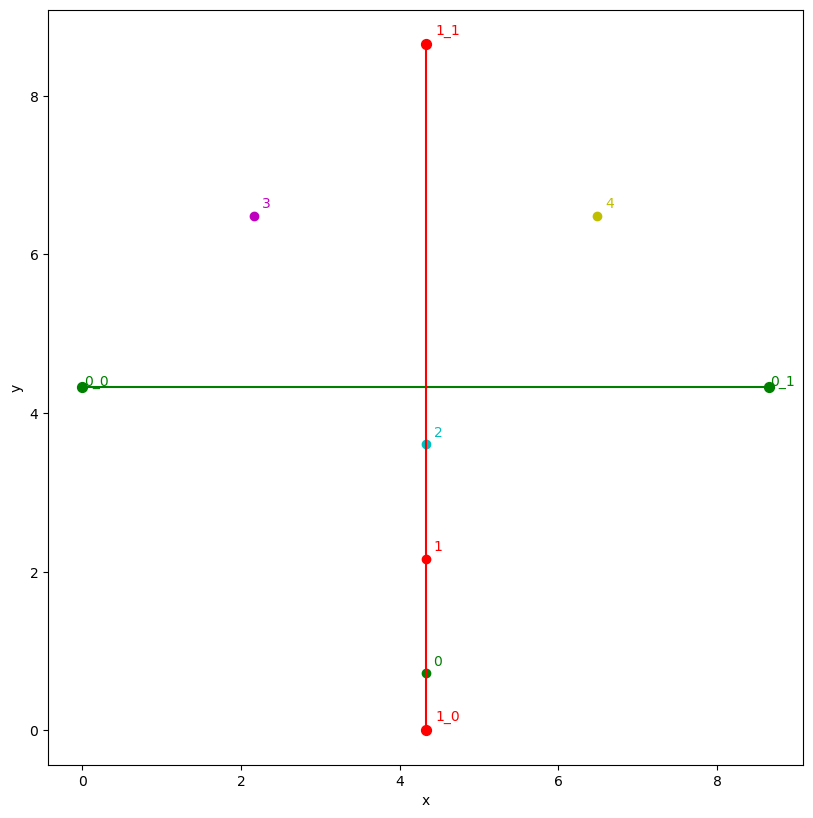

In [44]:
# 確認
horizon_side = [[0, geometric_net_cp[1]],[geometric_net_size[0], geometric_net_cp[1]]]
vertical_side = [[geometric_net_cp[0], 0],[geometric_net_cp[0], geometric_net_size[1]]]

lines = []
lines.append(horizon_side)
lines.append(vertical_side)

points = []
points.append(outer_side_surface_cp_on_geometric_net)
for i in range(len(inner_side_surface_cp_on_geometric_net_list)):
    points.append(inner_side_surface_cp_on_geometric_net_list[i])
points.append(top_surface_cp_on_geometric_net)
points.append(bottom_surface_cp_on_geometric_net)

Display_Sides_And_Points(lines, points, 0.1)

#### 展開図の作成

In [45]:
outer_side_point_on_geometric_net = []

start_p1 = [-figure_perimeter/2, figure_height_half]
start_p2 = [-figure_perimeter/2, -figure_height_half]
print("start_p : " + str(start_p1))
print("start_p : " + str(start_p2))

ls1 = []
ls2 = []
ls1.append(start_p1)
ls2.append(start_p2)
px = 0
for i in range(len(outer_side_norm_list)):
  px += outer_side_norm_list[i]
  p1 = [start_p1[0]+px, start_p1[1]]
  p2 = [start_p2[0]+px, start_p2[1]]
  ls1.append(p1)
  ls2.append(p2)

outer_side_point_on_geometric_net = ls1 + ls2
print("outer_side_point_on_geometric_net : " + str(len(outer_side_point_on_geometric_net)))
print(outer_side_point_on_geometric_net)

start_p : [-3.0464, 0.25]
start_p : [-3.0464, -0.25]
outer_side_point_on_geometric_net : 14
[[-3.0464, 0.25], [-1.979629171752433, 0.25], [-1.009577626730211, 0.25], [-0.006133557536516676, 0.25], [1.0692733421995788, 0.25], [2.029325424120138, 0.25], [3.0464291553098333, 0.25], [-3.0464, -0.25], [-1.979629171752433, -0.25], [-1.009577626730211, -0.25], [-0.006133557536516676, -0.25], [1.0692733421995788, -0.25], [2.029325424120138, -0.25], [3.0464291553098333, -0.25]]


In [46]:
inner_side_point_on_geometric_net_list = []

for i in range(len(holes_norms_list)):
    norms_list = holes_norms_list[i]
    ls1 = []
    ls2 = []
    ls1.append(start_p1)
    ls2.append(start_p2)
    px = 0

    for n in range(len(norms_list)):
        px += norms_list[n]
        p1 = [start_p1[0]+px, start_p1[1]]
        p2 = [start_p2[0]+px, start_p2[1]]
        ls1.append(p1)
        ls2.append(p2)
    tmp_list = ls1 + ls2
    inner_side_point_on_geometric_net_list.append(tmp_list)

print("inner_side_point_on_geometric_net_list : " + str(len(inner_side_point_on_geometric_net_list)))
print(inner_side_point_on_geometric_net_list)
if len(inner_side_point_on_geometric_net_list) > 0:
    print("inner_side_point_on_geometric_net_list[0] : " + str(len(inner_side_point_on_geometric_net_list[0])))
    print(inner_side_point_on_geometric_net_list[0])

inner_side_point_on_geometric_net_list : 2
[[[-3.0464, 0.25], [-2.2946021548315003, 0.25], [-1.5345363682051059, 0.25], [-0.7874754603803154, 0.25], [-0.03740879667634811, 0.25], [-3.0464, -0.25], [-2.2946021548315003, -0.25], [-1.5345363682051059, -0.25], [-0.7874754603803154, -0.25], [-0.03740879667634811, -0.25]], [[-3.0464, 0.25], [-2.2897627024789227, 0.25], [-1.5114953962145516, 0.25], [-0.7684610766841544, 0.25], [0.005683612634321822, 0.25], [-3.0464, -0.25], [-2.2897627024789227, -0.25], [-1.5114953962145516, -0.25], [-0.7684610766841544, -0.25], [0.005683612634321822, -0.25]]]
inner_side_point_on_geometric_net_list[0] : 10
[[-3.0464, 0.25], [-2.2946021548315003, 0.25], [-1.5345363682051059, 0.25], [-0.7874754603803154, 0.25], [-0.03740879667634811, 0.25], [-3.0464, -0.25], [-2.2946021548315003, -0.25], [-1.5345363682051059, -0.25], [-0.7874754603803154, -0.25], [-0.03740879667634811, -0.25]]


In [47]:
outer_side_surface_p_on_geometric_net = []
inner_side_surface_p_on_geometric_net_list = []
top_surface_p_on_geometric_net = []
bottom_surface_p_on_geometric_net = []

for i in range(len(outer_side_point_on_geometric_net)):
  old_p = outer_side_point_on_geometric_net[i]
  s_p = [old_p[0] + outer_side_surface_cp_on_geometric_net[0], old_p[1] + outer_side_surface_cp_on_geometric_net[1]]
  outer_side_surface_p_on_geometric_net.append(s_p)

for i in range(len(inner_side_point_on_geometric_net_list)):
  p_list = inner_side_point_on_geometric_net_list[i]

  tmp_list = []
  for n in range(len(p_list)):
    old_p = p_list[n]
    s_p = [old_p[0] + inner_side_surface_cp_on_geometric_net_list[i][0], old_p[1] + inner_side_surface_cp_on_geometric_net_list[i][1]]
    tmp_list.append(s_p)
  inner_side_surface_p_on_geometric_net_list.append(tmp_list)

for i in range(len(figure_position_with_holes)):
  old_p = figure_position_with_holes[i]

  t_diff = [top_surface_cp_on_geometric_net[0], top_surface_cp_on_geometric_net[1]]
  b_diff = [bottom_surface_cp_on_geometric_net[0], bottom_surface_cp_on_geometric_net[1]]


  t_p = [old_p[0] + t_diff[0], old_p[1] + t_diff[1]]
  b_p = [old_p[0] + b_diff[0], old_p[1] + b_diff[1]]

  top_surface_p_on_geometric_net.append(t_p)
  bottom_surface_p_on_geometric_net.append(b_p)

print("outer_side_surface_p_on_geometric_net : " + str(len(outer_side_surface_p_on_geometric_net)))
print(outer_side_surface_p_on_geometric_net)
print("inner_side_surface_p_on_geometric_net_list : " + str(len(inner_side_surface_p_on_geometric_net_list)))
print(inner_side_surface_p_on_geometric_net_list)
if len(inner_side_surface_p_on_geometric_net_list) > 0:
    print("inner_side_surface_p_on_geometric_net_list[0] : " + str(len(inner_side_surface_p_on_geometric_net_list[0])))
    print(inner_side_surface_p_on_geometric_net_list[0])
print("top_surface_p_on_geometric_net : " + str(len(top_surface_p_on_geometric_net)))
print(top_surface_p_on_geometric_net)
print("bottom_surface_p_on_geometric_net : " + str(len(bottom_surface_p_on_geometric_net)))
print(bottom_surface_p_on_geometric_net)

outer_side_surface_p_on_geometric_net : 14
[[1.2794879999999997, 0.971], [2.346258828247567, 0.971], [3.316310373269789, 0.971], [4.319754442463483, 0.971], [5.395161342199579, 0.971], [6.355213424120138, 0.971], [7.372317155309833, 0.971], [1.2794879999999997, 0.471], [2.346258828247567, 0.471], [3.316310373269789, 0.471], [4.319754442463483, 0.471], [5.395161342199579, 0.471], [6.355213424120138, 0.471], [7.372317155309833, 0.471]]
inner_side_surface_p_on_geometric_net_list : 2
[[[1.2794879999999997, 2.413], [2.0312858451684996, 2.413], [2.7913516317948943, 2.413], [3.5384125396196846, 2.413], [4.288479203323652, 2.413], [1.2794879999999997, 1.9129999999999998], [2.0312858451684996, 1.9129999999999998], [2.7913516317948943, 1.9129999999999998], [3.5384125396196846, 1.9129999999999998], [4.288479203323652, 1.9129999999999998]], [[1.2794879999999997, 3.855], [2.0361252975210773, 3.855], [2.814392603785448, 3.855], [3.5574269233158455, 3.855], [4.331571612634322, 3.855], [1.279487999999

/var/folders/4l/m0byp3xn42jbp2657xg83hmw0000gn/T/ipykernel_28592/231197490.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


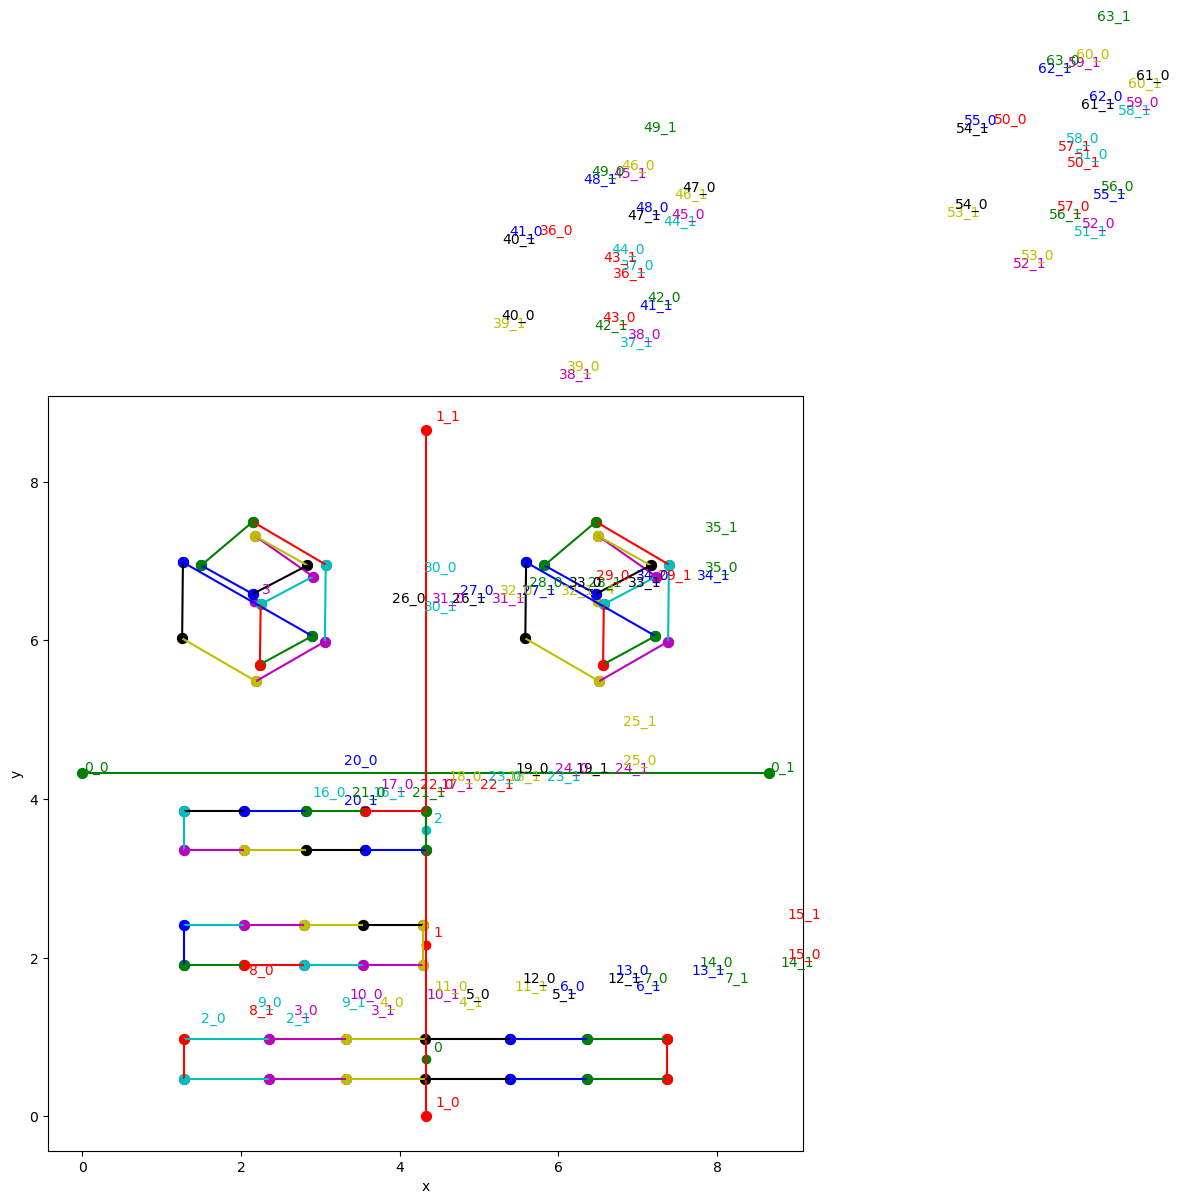

In [48]:
# 確認
horizon_side = [[0, geometric_net_cp[1]],[geometric_net_size[0], geometric_net_cp[1]]]
vertical_side = [[geometric_net_cp[0], 0],[geometric_net_cp[0], geometric_net_size[1]]]

lines = []
lines.append(horizon_side)
lines.append(vertical_side)

ls = outer_side_surface_p_on_geometric_net
for n in range(len(ls)):
  if n != len(ls) - 1 and n != int(len(ls)/2 - 1):
    p1 = ls[n]
    p2 = ls[n+1]
  elif n == int(len(ls)/2 - 1):
    p1 = ls[0]
    p2 = ls[n+1]
  else:
    p1 = ls[n]
    p2 = ls[int(len(ls)/2 - 1)]
  lines.append([p1, p2])

for i in range(len(inner_side_surface_p_on_geometric_net_list)):
  ls = inner_side_surface_p_on_geometric_net_list[i]
  for n in range(len(ls)):
    if n != len(ls) - 1 and n != int(len(ls)/2 - 1):
      p1 = ls[n]
      p2 = ls[n+1]
    elif n == int(len(ls)/2 - 1):
      p1 = ls[0]
      p2 = ls[n+1]
    else:
      p1 = ls[n]
      p2 = ls[int(len(ls)/2 - 1)]
    lines.append([p1, p2])

ls = top_surface_p_on_geometric_net
for n in range(len(ls)):
  if n != (len(ls) - 1):
    p1 = ls[n]
    p2 = ls[n+1]
  else:
    p1 = ls[n]
    p2 = ls[0]
  lines.append([p1, p2])

ls = bottom_surface_p_on_geometric_net
for n in range(len(ls)):
  if n != (len(ls) - 1):
    p1 = ls[n]
    p2 = ls[n+1]
  else:
    p1 = ls[n]
    p2 = ls[0]
  lines.append([p1, p2])

points = []
points.append(outer_side_surface_cp_on_geometric_net)
for i in range(len(inner_side_surface_cp_on_geometric_net_list)):
  points.append(inner_side_surface_cp_on_geometric_net_list[i])
points.append(top_surface_cp_on_geometric_net)
points.append(bottom_surface_cp_on_geometric_net)

Display_Sides_And_Points(lines, points, 0.1)

#### UVの算出

In [49]:
uv_map_size_on_pixel = [100, 100]
original_uv_map_size = [1, 1]

In [50]:
outer_side_surface_uv = []
inner_side_surface_uv_list = []
top_surface_uv = []
bottom_surface_uv = []

for i in range(len(outer_side_surface_p_on_geometric_net)):
  uvx = outer_side_surface_p_on_geometric_net[i][0] / geometric_net_size[0]
  uvy = outer_side_surface_p_on_geometric_net[i][1] / geometric_net_size[0]
  uv = [uvx, uvy]
  outer_side_surface_uv.append(uv)

for i in range(len(inner_side_surface_p_on_geometric_net_list)):
  p_list = inner_side_surface_p_on_geometric_net_list[i]
  tmp_list = []

  for n in range(len(p_list)):
    uvx = p_list[n][0] / geometric_net_size[0]
    uvy = p_list[n][1] / geometric_net_size[0]
    uv = [uvx, uvy]
    tmp_list.append(uv)

  inner_side_surface_uv_list.append(tmp_list)

for i in range(len(top_surface_p_on_geometric_net)):
  t_uvx = top_surface_p_on_geometric_net[i][0] / geometric_net_size[0]
  t_uvy = top_surface_p_on_geometric_net[i][1] / geometric_net_size[0]

  b_uvx = bottom_surface_p_on_geometric_net[i][0] / geometric_net_size[0]
  b_uvy = bottom_surface_p_on_geometric_net[i][1] / geometric_net_size[0]

  t_uv = [t_uvx, t_uvy]
  b_uv = [b_uvx, b_uvy]

  top_surface_uv.append(t_uv)
  bottom_surface_uv.append(b_uv)

print("outer_side_surface_uv")
print("length : " + str(len(outer_side_surface_uv)))
print(outer_side_surface_uv)
print("inner_side_surface_uv_list")
print("length : " + str(len(inner_side_surface_uv_list)))
print(inner_side_surface_uv_list)
if len(inner_side_surface_uv_list) != 0:
  print("inner_side_surface_uv_list[0]")
  print("length : " + str(len(inner_side_surface_uv_list[0])))
  print(inner_side_surface_uv_list[0])
print("top_surface_uv")
print("length : " + str(len(top_surface_uv)))
print(top_surface_uv)
print("bottom_surface_uv")
print("length : " + str(len(bottom_surface_uv)))
print(bottom_surface_uv)

# 上面下面側面の結合
all_uv = top_surface_uv + outer_side_surface_uv + bottom_surface_uv
if len(inner_side_surface_uv_list) != 0:
  for i in range(len(inner_side_surface_uv_list)):
    all_uv = all_uv + inner_side_surface_uv_list[i]
print("all_uv : " + str(len(all_uv)))
print(all_uv[:])

outer_side_surface_uv
length : 14
[[0.14788732394366194, 0.11223129216475322], [0.2711881153935986, 0.11223129216475322], [0.38330978209211486, 0.11223129216475322], [0.4992910637611842, 0.11223129216475322], [0.6235900400333503, 0.11223129216475322], [0.7345559367371668, 0.11223129216475322], [0.8521160459204946, 0.11223129216475322], [0.14788732394366194, 0.05443968960823766], [0.2711881153935986, 0.05443968960823766], [0.38330978209211486, 0.05443968960823766], [0.4992910637611842, 0.05443968960823766], [0.6235900400333503, 0.05443968960823766], [0.7345559367371668, 0.05443968960823766], [0.8521160459204946, 0.05443968960823766]]
inner_side_surface_uv_list
length : 2
[[[0.14788732394366194, 0.2789022739377441], [0.23478252848530748, 0.2789022739377441], [0.32263336820034344, 0.2789022739377441], [0.4089810623413834, 0.2789022739377441], [0.495676171380726, 0.2789022739377441], [0.14788732394366194, 0.22111067138122853], [0.23478252848530748, 0.22111067138122853], [0.3226333682003434

#### 側面のObj上の面積とUV Map上の面積の比率を算出。UV Map Scaleとして利用

In [51]:
# uv_map_scaleの計算
side_surface_area_size_on_obj = figure_perimeter * figure_height
side_surface_area_size_on_uv_map = 0

start_p = outer_side_surface_uv[0]
end_p = outer_side_surface_uv[-1]
side_surface_width = end_p[0] - start_p[0]
side_surface_height = start_p[1] - end_p[1]
side_surface_area_size_on_uv_map = side_surface_width * side_surface_height


material_tiling_num = geometric_net_size[0] / material_adjustment_scale 
material_tiling_num = round(material_tiling_num , round_num_01)

print("material_adjustment_scale : " + str(material_adjustment_scale))
print("geometric_net_size : " + str(geometric_net_size))
print("material_scale : " + str(material_tiling_num))

material_adjustment_scale : 2
geometric_net_size : [8.651776, 8.651776]
material_scale : 4.3259


## Normalの作成

In [52]:
# 面法線
top_surface_normal = [[-0.0000, 1.0000, -0.0000]]
bottom_surface_normal = [[-0.0000, -1.0000, -0.0000]]
outer_side_surface_normal = outer_side_normal

all_surface_normal = top_surface_normal +  outer_side_surface_normal + bottom_surface_normal + inner_side_normal
print("all_surface_normal : " + str(len(all_surface_normal)))
print(all_surface_normal)

all_surface_normal : 16
[[-0.0, 1.0, -0.0], array([0.50620057, 0.        , 0.86241578]), array([ 0.99994686,  0.        , -0.01030873]), array([ 0.49828388,  0.        , -0.86701394]), array([-0.50213552, -0.        , -0.86478895]), array([-0.99994575,  0.        ,  0.0104161 ]), array([-0.50142378,  0.        ,  0.86520182]), [-0.0, -1.0, -0.0], array([-0.47885213,  0.        ,  0.87789557]), array([ 0.99991345,  0.        , -0.01315676]), array([ 0.46850263,  0.        , -0.8834621 ]), array([-0.99991112,  0.        ,  0.01333215]), array([-0.48900576, -0.        , -0.87228055]), array([-0.46256601,  0.        ,  0.88658485]), array([0.48449983, 0.        , 0.87479136]), array([ 0.47794683,  0.        , -0.87838877])]


## データの整形

In [53]:
top_surface_position_length = len(figure_position_with_holes)

inner_side_normal_length = len(inner_side_normal)
inner_side_uv_length = 0
inner_side_position_length = 0 

if len(inner_side_surface_uv_list) != 0:
    for i in range(len(inner_side_surface_uv_list)):
        inner_side_uv_length += len(inner_side_surface_uv_list[i])

if len(holes_position_list_original) != 0:
    for i in range(len(holes_position_list_original)):
        inner_side_position_length += len(holes_position_list_original[i])

print("top_surface_position_length : " + str(top_surface_position_length))
print("inner_side_normal_length : " + str(inner_side_normal_length))
print("inner_side_uv_length : " + str(inner_side_uv_length))
print("inner_side_position_length : " + str(inner_side_position_length))

top_surface_position_length : 14
inner_side_normal_length : 8
inner_side_uv_length : 20
inner_side_position_length : 8


In [54]:
comment_str = "# "
now = datetime.datetime.now()
date_str = now.strftime('%Y%m%d_%H%M%S')
header_str = "o " + new_obj_name + "_" + date_str
print(header_str)

# v 頂点
v_str = ""
for i in range(len(position_with_hole)):
  p = position_with_hole[i]
  txt = "v " + str(p[0]) + " " + str(p[1]) + " " + str(p[2]) + "\n"
  v_str += txt

# vn 法線
n_str = ""
for i in range(len(all_surface_normal)):
  n = all_surface_normal[i]
  txt = "vn " + str(n[0]) + " " + str(n[1]) + " " + str(n[2]) + "\n"
  n_str += txt

# vt テクスチャ座標(UV)
t_str = ""
for i in range(len(all_uv)):
  t = all_uv[i]
  txt = "vt " + str(t[0]) + " " + str(t[1]) + "\n"
  t_str += txt

# f 頂点番号/テクスチャ座標(UV)/法線番号 番号は全て"1"から始まる
f_str = ""
# top
for i in range(len(top_surface_triangle)):
  v_n1 = top_surface_triangle[i][0] + 1
  v_n2 = top_surface_triangle[i][1] + 1
  v_n3 = top_surface_triangle[i][2] + 1

  t_n1 = v_n1
  t_n2 = v_n2
  t_n3 = v_n3

  n_n1 = 1
  n_n2 = 1
  n_n3 = 1
  txt =  "f " + str(v_n1) + "/" + str(t_n1) + "/" + str(n_n1) + " " + str(v_n2) + "/" + str(t_n2) + "/" + str(n_n2) + " " + str(v_n3) + "/" + str(t_n3) + "/" + str(n_n3) +"\n"
  f_str += txt


# outer_side
f_str += "outer_side\n"
for i in range(len(outer_side_surface_triangle)):

  v_n1 = outer_side_surface_triangle[i][0] + 1
  v_n2 = outer_side_surface_triangle[i][1] + 1
  v_n3 = outer_side_surface_triangle[i][2] + 1

  i1 = outer_side_index_list.index(outer_side_surface_triangle[i][0])
  i2 = outer_side_index_list.index(outer_side_surface_triangle[i][1])
  i3 = outer_side_index_list.index(outer_side_surface_triangle[i][2])

  t_n1 = i1 + 1 + len(top_surface_uv)
  if i1 >= outer_side_position_length:
    t_n1 += 1
  if(i > 1 and i1 == 0):
    t_n1 = outer_side_position_length + 1 + len(top_surface_uv)
  elif(i > 1 and i1 == outer_side_position_length): 
    t_n1 = outer_side_position_length * 2 + 2 + len(top_surface_uv)

  t_n2 = i2 + 1 + len(top_surface_uv)
  if i2 >= outer_side_position_length:
    t_n2 += 1
  if(i > 1 and i2 == 0):
    t_n2 = outer_side_position_length + 1 + len(top_surface_uv)
  elif(i > 1 and i2 == outer_side_position_length): 
    t_n2 = outer_side_position_length * 2 + 2 + len(top_surface_uv)

  t_n3 = i3 + 1 + len(top_surface_uv)
  if i3 >= outer_side_position_length:
    t_n3 += 1
  if(i > 1 and i3 == 0):
    t_n3 = outer_side_position_length + 1 + len(top_surface_uv)
  elif(i > 1 and i3 == outer_side_position_length): 
    t_n3 = outer_side_position_length * 2 + 2 + len(top_surface_uv)

  num = int(i / 2) + 1 + 1
  n_n1 = num
  n_n2 = num
  n_n3 = num
  txt =  "f " + str(v_n1) + "/" + str(t_n1) + "/" + str(n_n1) + " " + str(v_n2) + "/" + str(t_n2) + "/" + str(n_n2) + " " + str(v_n3) + "/" + str(t_n3) + "/" + str(n_n3) +"\n"
  f_str += txt

# inner_side
uv_additional_num = 0
normal_additional_num = 0
for i in range(len(inner_side_surface_triangle_list)):
    triangle_list = inner_side_surface_triangle_list[i]
    index_list = inner_side_index_list[i]
    position_length = int(len(index_list) / 2)
    print(i)
    print(triangle_list)
    print(index_list)

    for n in range(len(data)):
      v_n1 = triangle_list[n][0] + 1
      v_n2 = triangle_list[n][1] + 1
      v_n3 = triangle_list[n][2] + 1

      i1 = index_list.index(triangle_list[n][0])
      i2 = index_list.index(triangle_list[n][1])
      i3 = index_list.index(triangle_list[n][2])

      additional_num = len(top_surface_uv) + len(outer_side_surface_uv) +len(bottom_surface_uv) + uv_additional_num

      t_n1 = i1 + 1 + additional_num
      if i1 >= position_length:
        t_n1 += 1
      if(n > 1 and i1 == 0):
        t_n1 = position_length + 1 + additional_num
      elif(n > 1 and i1 == position_length):
        t_n1 = position_length * 2 + 2 + additional_num

      t_n2 = i2 + 1 + additional_num
      if i2 >= position_length:
        t_n2 += 1
      if(n > 1 and i2 == 0):
        t_n2 = position_length + 1 + additional_num
      elif(n > 1 and i2 == position_length):
        t_n2 = position_length * 2 + 2 + additional_num

      t_n3 = i3 + 1 + additional_num
      if i3 >= position_length:
        t_n3 += 1
      if(n > 1 and i3 == 0):
        t_n3 = position_length + 1 + additional_num
      elif(n > 1 and i3 == position_length):
        t_n3 = position_length * 2 + 2 + additional_num

      additional_num = len(top_surface_normal) + len(outer_side_surface_normal) + len(bottom_surface_normal) + normal_additional_num
      num = int(n / 2) + 1 + additional_num #v_n1 #int(i / 2) + 1 + 1
      n_n1 = num
      n_n2 = num
      n_n3 = num

      txt =  "f " + str(v_n1) + "/" + str(t_n1) + "/" + str(n_n1) + " " + str(v_n2) + "/" + str(t_n2) + "/" + str(n_n2) + " " + str(v_n3) + "/" + str(t_n3) + "/" + str(n_n3) +"\n"
      f_str += txt
      
    uv_additional_num += len(inner_side_surface_uv_list[i])
    normal_additional_num += len(inner_side_normal[i])

# bottom
for i in range(len(bottom_surface_triangle)):
  v_n1 = bottom_surface_triangle[i][0] + 1 + len(top_surface_position)
  v_n2 = bottom_surface_triangle[i][1] + 1 + len(top_surface_position)
  v_n3 = bottom_surface_triangle[i][2] + 1 + len(top_surface_position)

  t_n1 = bottom_surface_triangle[i][0] + 1 + len(top_surface_uv) + len(outer_side_surface_uv)
  t_n2 = bottom_surface_triangle[i][1] + 1 + len(top_surface_uv) + len(outer_side_surface_uv)
  t_n3 = bottom_surface_triangle[i][2] + 1 + len(top_surface_uv) + len(outer_side_surface_uv)

  num = len(all_surface_normal) - inner_side_normal_length
  n_n1 = num
  n_n2 = num
  n_n3 = num
  txt =  "f " + str(v_n1) + "/" + str(t_n1) + "/" + str(n_n1) + " " + str(v_n2) + "/" + str(t_n2) + "/" + str(n_n2) + " " + str(v_n3) + "/" + str(t_n3) + "/" + str(n_n3) +"\n"
  f_str += txt

print("v_str")
print(v_str)
print("n_str")
print(n_str)
print("t_str")
print(t_str)
print("f_str")
print(f_str)

o New_Obj_20240603_000920
0
[[6, 7, 21], [21, 20, 6], [7, 8, 22], [22, 21, 7], [8, 9, 23], [23, 22, 8], [9, 6, 20], [20, 23, 9]]
[6, 7, 8, 9, 20, 21, 22, 23]
1
[[10, 11, 25], [25, 24, 10], [11, 12, 26], [26, 25, 11], [12, 13, 27], [27, 26, 12], [13, 10, 24], [24, 27, 13]]
[10, 11, 12, 13, 24, 25, 26, 27]
v_str
v -0.0167 0.25 1.0067
v 0.9033 0.25 0.4667
v 0.8933 0.25 -0.5033
v 0.0233 0.25 -1.0033
v -0.9067 0.25 -0.4633
v -0.8967 0.25 0.4967
v 0.7333 0.25 -0.4333
v 0.0733 0.25 -0.7933
v 0.0833 0.25 -0.0333
v 0.7433 0.25 0.3167
v 0.0133 0.25 0.8267
v 0.6733 0.25 0.4567
v -0.0167 0.25 0.0967
v -0.6667 0.25 0.4567
v -0.0167 -0.25 1.0067
v 0.9033 -0.25 0.4667
v 0.8933 -0.25 -0.5033
v 0.0233 -0.25 -1.0033
v -0.9067 -0.25 -0.4633
v -0.8967 -0.25 0.4967
v 0.7333 -0.25 -0.4333
v 0.0733 -0.25 -0.7933
v 0.0833 -0.25 -0.0333
v 0.7433 -0.25 0.3167
v 0.0133 -0.25 0.8267
v 0.6733 -0.25 0.4567
v -0.0167 -0.25 0.0967
v -0.6667 -0.25 0.4567

n_str
vn -0.0 1.0 -0.0
vn 0.5062005687642233 0.0 0.862415783820

## Objファイルへ出力

In [55]:
new_obj_path = new_obj_folder_path + new_obj_name  + "_" + date_str + "_" + "tiling_" + str(material_tiling_num) + ".obj"

with open(new_obj_path, 'w') as f:
    f.write(header_str)
    f.write("\n")
    f.write(v_str)
    f.write(n_str)
    f.write(t_str)
    f.write(f_str)

print("Done! Created New Obj File. " + new_obj_path)

Done! Created New Obj File. 20240603_000920
